In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_14-52_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
GC       0.25
YM       0.25
ES       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27465.90
GC    11629.32
NQ    37839.80
YM    30233.20
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

107168.22

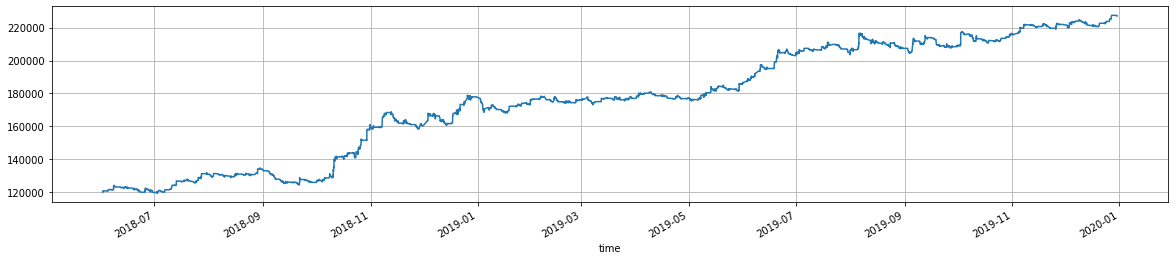

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     546
 GC    1055
 NQ    2013
 YM     558
 Name: action, dtype: int64,
 4172)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.325243
 GC    2.560680
 NQ    4.885922
 YM    1.354369
 Name: action, dtype: float64,
 10.12621359223301)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1146.6
GC    2553.1
NQ    4227.3
YM    1171.8
Name: commission, dtype: float64

In [15]:
df.commission.sum()

9098.800000000003

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,22.07,458.35,-253.48,1.81,24.13,527.0
NQ,0.40,37.61,464.96,-247.99,1.87,37.19,1006.0
ES,0.41,100.61,956.96,-495.12,1.93,100.23,273.0
YM,0.42,108.36,762.85,-364.32,2.09,109.09,279.0
total,0.40,51.40,570.95,-296.35,1.93,50.57,2085.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.009761,0.186623,0.522665,0.717827
GC,0.009761,1.000000,0.094173,0.045960,0.371158
NQ,0.186623,0.094173,1.000000,0.300259,0.667824
YM,0.522665,0.045960,0.300259,1.000000,0.742706
total,0.717827,0.371158,0.667824,0.742706,1.000000


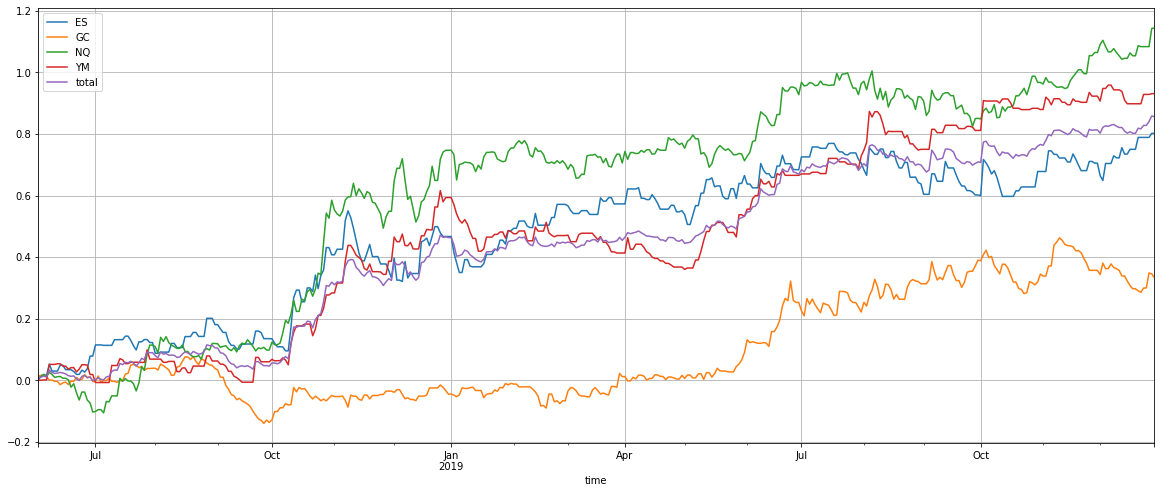

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

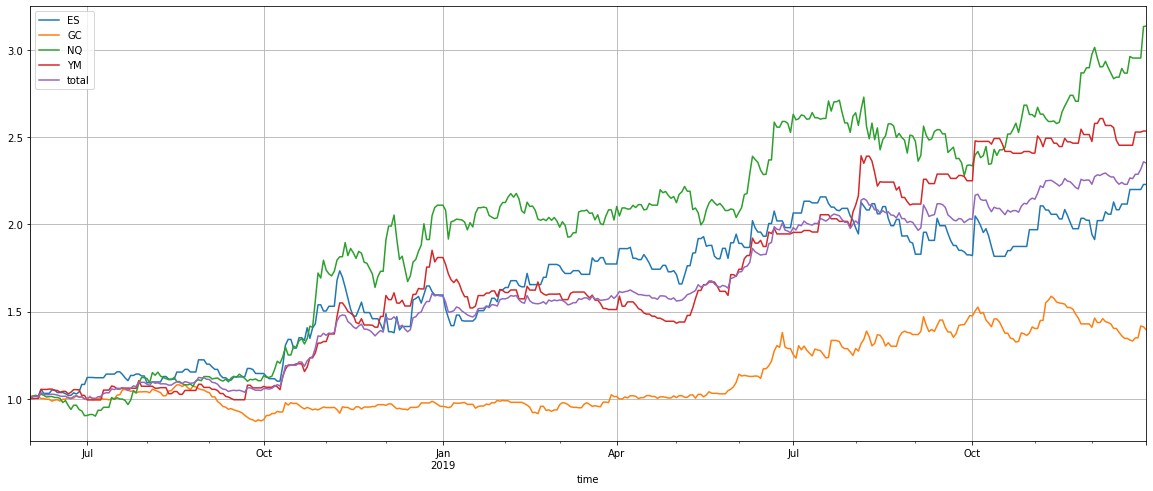

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.633181,0.226002,1.013226,0.767198,0.687779
Cumulative returns,1.229945,0.395327,2.139354,1.536831,1.353114
Annual volatility,0.376522,0.259962,0.379344,0.308945,0.213335
Sharpe ratio,1.487255,0.912065,2.033753,1.995193,2.560510
Calmar ratio,3.087505,1.157786,5.448521,3.394493,8.117347
Stability,0.860984,0.679285,0.858071,0.919681,0.951425
Max drawdown,-0.205078,-0.195202,-0.185964,-0.226012,-0.084730
Omega ratio,1.393747,1.189916,1.461997,1.619817,1.657007
Sortino ratio,2.891150,1.628620,3.591931,4.350184,5.659485
Skew,1.541153,1.203770,0.775795,1.953735,1.880746


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,8.16,-0.40,-9.80,1.88,-0.12
2018-07-31,4.50,4.39,24.28,5.12,9.50
2018-08-31,6.00,-0.06,0.52,-0.61,1.61
2018-09-30,-4.46,-16.08,-2.11,-0.26,-5.82
2018-10-31,31.32,9.13,62.72,25.07,31.39
2018-11-30,-7.32,1.44,-3.54,10.85,0.51
2018-12-31,14.50,-0.97,21.93,22.98,14.98
2019-01-31,1.90,3.54,0.73,-10.46,-0.99
2019-02-28,8.93,-5.50,-5.03,-1.28,-0.73


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       123.0
GC        40.0
NQ       214.0
YM       154.0
total    135.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:32:30,ES,BUY,2885.25,3745.80
2018-10-11 04:24:00,ES,BUY,2767.00,3395.80
2018-12-17 17:03:00,ES,BUY,2597.00,3233.30
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
...,...,...,...,...
2018-11-13 19:11:00,ES,SELL,2731.00,-1166.70
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.20
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.124860,0.019355,0.026633,0.101693,0.068135
2019-08-05,0.093470,0.034011,0.035793,0.106360,0.067409
2019-09-05,0.068887,0.061011,0.070387,0.067220,0.066876
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
2018-10-11,0.101107,0.057183,0.045967,0.035940,0.060049
...,...,...,...,...,...
2019-09-18,-0.022640,-0.018656,-0.042393,0.000000,-0.020922
2019-01-02,-0.050973,-0.003495,-0.013920,-0.022307,-0.022674
2018-11-13,-0.038890,0.000011,-0.039367,-0.017613,-0.023965
